In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pickle

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [4]:
df = pd.read_excel('FullChatbotDataset.xlsx')
df = df[['Question', 'Topic']]

# Analyse Dataset

In [5]:
# count each topic
df['Topic'].value_counts()

Topic
Fintech           240
Digitalization    187
ArTech            159
Irrelevant        102
PropTech           33
Name: count, dtype: int64

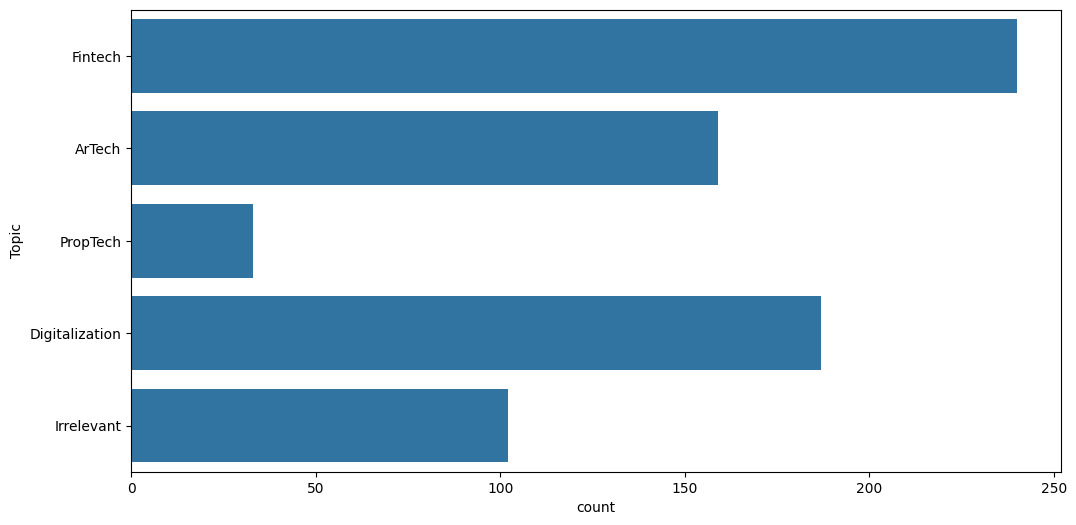

In [6]:
#plot the count of each topic
plt.figure(figsize=(12,6))
sns.countplot(df['Topic'])
plt.show()

# Feature Construction and Train Test Split

In [7]:
# Encode the topics into numerical labels
label_map = {"Fintech": 0, "ArTech": 1, "PropTech": 2, "Digitalization": 3, "Irrelevant": 4}
df['Topic'] = df['Topic'].map(label_map)

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load your dataset
questions = df['Question']

# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize words
    words = text.split()
    
    # Remove stop words and lemmatize
    processed_words = [
        lemmatizer.lemmatize(word) for word in words if word not in stop_words
    ]
    
    # Rejoin words into a single string
    return ' '.join(processed_words)

def preprocess_text_no_stopwords(text):
    text = text.lower()
    words = text.split()
    processed_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(processed_words)

df['Processed_Question'] = df['Question'].apply(preprocess_text)

df['Processed_Question_NoStop'] = df['Question'].apply(preprocess_text_no_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Experiment 1: Text Processing

This section is to investigate whether text processing can help increase the performance of the clssification model.

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Example pipelines
pipelines = {
    'raw_text': df['Question'],
    'processed_text': df['Processed_Question'],
    'processed_text_no_stopwords': df['Processed_Question_NoStop']
}

results = {}
for name, data in pipelines.items():
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    X = vectorizer.fit_transform(data)
    X_train, X_test, y_train, y_test = train_test_split(X, df['Topic'], test_size=0.2, random_state=42)

    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = accuracy_score(y_test, y_pred)

result_df = pd.DataFrame(results.items(), columns=['Text Processing', 'Accuracy'])
result_df


,Text Processing,Accuracy
0,raw_text,0.910345
1,processed_text,0.841379
2,processed_text_no_stopwords,0.896552


Result: The raw_text perform the best. We think that it is attributed to how the data is made. The raw question text is summarized from our collected knowledge base using ChatGPT, therefore, the raw text is already very concise and did not include lots of meaningless stop words. Thus, text processing does not improve the accuracy here.

# Experiment 2: Different Models

In [10]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['Question'], df['Topic'], test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [11]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [12]:
result_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Naive Bayes Model

In [13]:
# Define the model
model = MultinomialNB()

# Define the hyperparameter grid
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Evaluate on the test setres
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)


# Evaluate the model
accuracy = best_model.score(X_test_tfidf, y_test)
report = classification_report(y_test, y_pred, output_dict=True)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Save results
result_df = pd.concat([result_df, pd.DataFrame({'Model': "MultinomialNB", 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, index=[0])])

## Logistic Regression

In [14]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],              # Regularization type
    'solver': ['liblinear', 'saga'],      # Solvers that support l1
    'class_weight': [None, 'balanced'],   # Class imbalance
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=0)
grid_search.fit(X_train_tfidf, y_train)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

print("Best parameters found: ", grid_search.best_params_)
print("Best train score found: ", grid_search.best_score_)



# Evaluate the model
accuracy = best_model.score(X_test_tfidf, y_test)
report = classification_report(y_test, y_pred, output_dict=True)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Save results
result_df = pd.concat([result_df, pd.DataFrame({'Model': "LogisticRegression", 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, index=[0])])

Best parameters found:  {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best train score found:  0.967031484257871


## Random Forest

In [15]:
# Initialize RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [50,100, 200, 300],         # Number of trees
    'max_depth': [10, 20, 30, None],         # Tree depth
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_tfidf, y_train)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)


print("Best parameters found: ", grid_search.best_params_)
print("Best train score found: ", grid_search.best_score_)

# Evaluate the model
accuracy = best_model.score(X_test_tfidf, y_test)
report = classification_report(y_test, y_pred, output_dict=True)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Save results
result_df = pd.concat([result_df, pd.DataFrame({'Model': "Random Forest", 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, index=[0])])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found:  {'max_depth': None, 'n_estimators': 50}
Best train score found:  0.949655172413793


# SVM

In [16]:
# Initialize SVC
model = SVC(kernel='linear', probability=True)

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization strength
    'class_weight': [None, 'balanced'],         # Class weighting
}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_tfidf, y_train)
# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_tfidf)


print("Best parameters found: ", grid_search.best_params_)
print("Best train score found: ", grid_search.best_score_)

# Evaluate the model
accuracy = best_model.score(X_test_tfidf, y_test)
report = classification_report(y_test, y_pred, output_dict=True)
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

# Save results
result_df = pd.concat([result_df, pd.DataFrame({'Model': "SVM", 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1_score}, index=[0])])

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Best parameters found:  {'C': 10, 'class_weight': 'balanced'}
Best train score found:  0.9670314842578712


# Results

In [17]:
result_df

,Model,Accuracy,Precision,Recall,F1 Score
0,MultinomialNB,0.917241,0.750060,0.767411,0.757924
0,LogisticRegression,0.965517,0.973640,0.924675,0.943658
0,Random Forest,0.937931,0.951818,0.857064,0.880438
0,SVM,0.972414,0.983164,0.930736,0.951809


# Finalised Best Model (SVM)

In [18]:
final_model = best_model

#evaluate the model
y_pred = final_model.predict(X_test_tfidf)
report = classification_report(y_test, y_pred)
print(report)

#save the model
pickle.dump(final_model, open('classifier.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        56
           1       1.00      0.94      0.97        33
           2       1.00      0.71      0.83         7
           3       0.97      1.00      0.98        29
           4       1.00      1.00      1.00        20

    accuracy                           0.97       145
   macro avg       0.98      0.93      0.95       145
weighted avg       0.97      0.97      0.97       145

